## Single-wire example for time-harmonic Maxwell's equations

### Physical problem
A single copper wire of radius $r=0.5$, extending infinitely in the z-direction is placed in vacuum. Alternating current of $\mathbf{j} = j_z\sin(\omega t) \mathbf{e}_z$ passes through the wire.

### Weak form of the problem
From the derivation demonstrated in the notes, we know the weak form of the problem is given by

$$ \int_{\Omega} ({\mu^{-1} \nabla \times \mathbf{A}}) \cdot (\nabla \times \mathbf{v})
    - \omega^2 \int_{\Omega} \mathbf{A} \cdot \mathbf{v} 
    = \int_{\Omega} \mathbf{j} \cdot \mathbf{v} $$
    
for all $\mathbf{v} \in H_{\text{curl}}(\Omega)$ with boundary condition 

$$ \mathbf{v} \times \mathbf{n} = 0, ~\text{on}~\partial \Omega $$

with the normal vector $\mathbf{n}$ to $\partial \Omega$.

For this particular problem with an infinitely extending wire, we may assume $\mathbf{A} = A_z \mathbf{e}_z$ and $\mathbf{v} = v_z \mathbf{e}_z$. We then simplify

$$ \nabla \times \mathbf{A} = (\frac{\partial A_z}{\partial y}, -\frac{\partial A_z}{\partial x}, 0)^T $$

and equivalently also $\nabla \times \mathbf{v}$, such that we see 

$$ (\nabla \times \mathbf{A}) \cdot (\nabla \times \mathbf{v})
= \frac{\partial A_z}{\partial y} \frac{\partial v_z}{\partial y} + \frac{\partial A_z}{\partial x} \frac{\partial v_z}{\partial x} 
= (\nabla A_z) \cdot (\nabla v_z)$$

Consequently, we get the simplified weak form

$$ \int_{\Omega} (\mu^{-1} \nabla A_z) \cdot (\nabla v_z)
    - \omega^2 \int_{\Omega} A_z v_z
    = \int_{\Omega} j_z v_z $$

In [118]:
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix
%matplotlib inline

In [119]:
r = 0.5 # radius of wire
R = 5.0 # radius of domain

# Set the domain
domain = Circle(Point(0, 0), R)

In [120]:
# Generating the mesh
mesh = generate_mesh(domain, 32)

# Define function space
V = FunctionSpace(mesh, 'P', 1)

# Define integration measure
dx = Measure('dx', domain=mesh)

# Visuazlizing the mesh
mesh

### Verify correctness of implementation with a simple 'manufactured' example

Let us consider a simple problem $\mathbf{A} = \mathbf{e}_z$

By the definition of the curl operator, we have

$$ \nabla \times \mathbf{A} = (\partial_y A_z - \partial_z A_y, \partial_z A_x - \partial_x A_z, \partial_x A_y - \partial_y A_x)^T = (0, 0, 0)^T $$

and by the strong form of the problem

$$ \nabla \times (\mu^{-1} \nabla \times \mathbf{A}) - \omega^2 \mathbf{A} = \mathbf{j} $$

we see that we must have $\mathbf{j} = - \omega^2 \mathbf{e}_z$.

8.9442106976587994e-16

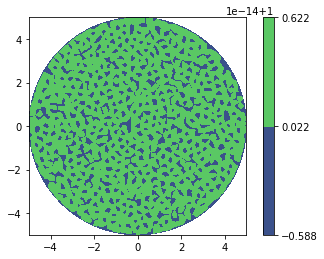

In [121]:
# Define boundary condition
bc = DirichletBC(V, Constant(1.0), 'on_boundary')

# Define variational problem
A_z = TrialFunction(V)
v_z = TestFunction(V)

# Define stiffness and mass matrix
mu = 1.0
a_stiff = (1 / mu)*dot(grad(A_z), grad(v_z))*dx
a_mass = A_z*v_z*dx
omega = 100
a = a_stiff - (omega**2)*a_mass

# Define current density
J = -omega**2
L = J*v_z*dx

# Solve variational problem
A_z = Function(V)
solve(a == L, A_z, bc)

plt.colorbar(plot(A_z))

# Mean absolute deviation from expected A_z = 1
np.mean(np.abs(np.array(A_z.compute_vertex_values(mesh)) - 1))

### Vector potential (finite element solution)

Since we can add any constant to the solution of $A_z$ without changing the physical outcome of the magnetic field strength $\mathbf{B}$, and because we are working with a radially symmetric domain, the boundary condition $A_z = 0$ should be ok. Due to this, however, it is no longer possible to compare $A_z(\omega)$ quantitatively for different $\omega$.

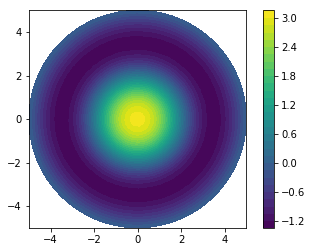

In [122]:
# Define boundary condition
bc = DirichletBC(V, Constant(0.0), 'on_boundary')

# Define variational problem
A_z = TrialFunction(V)
v_z = TestFunction(V)

# Define stiffness and mass matrix
mu = Expression('pow(x[0]*x[0] + x[1]*x[1], 0.5) < r ? 1.26e-6 : 4*pi*1e-7', degree=2, r=0.5) 
a_stiff = (1 / mu)*dot(grad(A_z), grad(v_z))*dx
a_mass = A_z*v_z*dx
omega = 1000
a = a_stiff - (omega**2)*a_mass

# Define current density (1 A)
J = Expression('pow(x[0]*x[0] + x[1]*x[1], 0.5) < r ? j : 0', degree=2, r=0.5, j=-omega*omega)
L = J*v_z*dx

# Solve variational problem
A_z = Function(V)
solve(a == L, A_z, bc)

plt.colorbar(plot(A_z))

### Magnetic field strength (finite element solution)

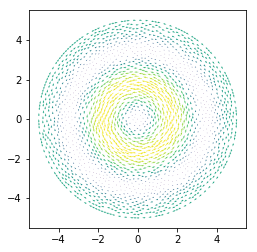

In [123]:
# Compute magnetic field (B = curl A)
W = VectorFunctionSpace(mesh, 'P', 1)
B = project(as_vector((A_z.dx(1), -A_z.dx(0))), W)

plot(B)

In [124]:
def export_form_as_sparse_matrix(a, fname):
    """
    Export form as sparse matrix
    
    Reference
    ---------
    https://fenicsproject.org/qa/14194/how-to-dump-fenics-matrix-to-an-text-file-matrix-market-format/
    """
    M = assemble(a)
    Mmat = as_backend_type(M).mat()
    mat = coo_matrix(csr_matrix(Mmat.getValuesCSR()[::-1]))

    np.savetxt(fname + '.txt',
               np.c_[mat.row, mat.col, mat.data],
               fmt=['%d', '%d', '%.16f']) 

In [125]:
def export_field_at_vertex_coordinates(A, mesh, fname):
    """
    Export vector field as sparse matrix
    """
    Avec = A.compute_vertex_values(mesh)
    coords = mesh.coordinates()
    x = coords[:, 0]
    y = coords[:, 1]
    np.savetxt(fname + '.txt',
               np.c_[Avec, x, y],
               fmt=['%.16f', '%.16f', '%.16f'])

In [126]:
export_form_as_sparse_matrix(a_stiff, "a_stiff")
export_form_as_sparse_matrix(a_mass, "a_mass")
export_field_at_vertex_coordinates(A_z, mesh, "A_vertex")

### Quickly verify correctness of exportation

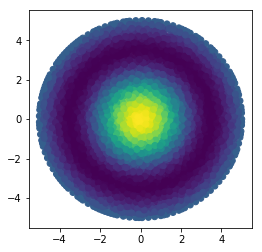

In [127]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

A_vertex = np.loadtxt('A_vertex.txt')

colors = A_vertex[:, 0]
norm = Normalize()
norm.autoscale(colors)
colormap = cm.viridis

plt.figure(figsize=(4, 4))
plt.scatter(A_vertex[:, 1], A_vertex[:, 2], color=colormap(norm(colors)))